# Implementing Batch Normalization in Tensorflow

Batch normalization, as described in the March 2015 [paper](http://arxiv.org/pdf/1502.03167v3.pdf) (the "BN2015") by Sergey Ioffe and Christian Szegedy, is a simple and (extremely) effective way to improve the performance of a neural network. In the BN2015 paper, Ioffe and Szegedy show that batch normalization enables the use of higher learning rates, acts as a regularizer and can speed up training by 14 times.

#### The Problem

Batch normalization is intended to solve the following problem: Changes in model parameters during learning change the distributions of the outputs of each hidden layer. This means that later layers need to adapt to these changes during training. 

#### Batch Normalization in Brief

To solve this problem, Ioffe and Szegedy "batch normalize" the input to each activation function (e.g., each sigmoid or ReLU function) during training so that the input to the activation function across each training batch has a mean of 0 and a variance of 1. For example, applying batch normalization to the activation $\sigma(Wx + b)$ would produce instead $\sigma(BN(Wx + b))$ where $BN$ is the "batch normalizing" transform.

#### The Batch Normalizing Transform

To normalize a value across a batch (i.e., to batch normalize the value), we subtract the batch mean, $\mu_B$, and then divide it by the batch standard deviation, $\sqrt{\sigma^2_B + \epsilon}$. Note that a small constant $\epsilon$ is added to the variance in order to avoid dividing by zero. 

Thus, the initial batch normalizing transform of a given value, $x_i$, is: $$BN(x_i) = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$

Because the batch normalizing transform given above restricts the inputs to the activation function to a prescribed normal distribution, this can limit the representational power of the layer. Therefore, we allow, but do not force, the network to undo the batch normalizing transform by multiplying by a new parameter $\gamma$ and adding a new parameter $\beta$. $\gamma$ and $\beta$ are learnable parameters. The batch normalizing transform can be reversed by choosing $\gamma$ = $\sqrt{\sigma^2_B + \epsilon}$ and $\epsilon$ = $\mu_B$ (note, however, that $\gamma$ and $\beta$ do not depend on the batch, so this would not undo the batch normalizing transform perfectly for each training batch). 

Adding in $\gamma$ and $\beta$ producing the following final batch normalizing transform: $$BN(x_i) = \gamma(\frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}) + \beta$$

#### Implementing Batch Normalization in Tensorflow

We will add batch normalization to a basic fully-connected neural network that has three hidden layers of 100 neurons each and show a similar result to Figure 1 (b) and (c) of the BN2015 paper. 

In [1]:
import numpy as np
import tensorflow as tf
import load_mnist
import matplotlib.pyplot as plt
%matplotlib inline
mnist = load_mnist.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
#Using randomly predetermined weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,100)).astype(np.float32)
w4_initial = np.random.normal(size=(100,10)).astype(np.float32)

In [3]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

In [4]:
epsilon = 1e-3

In [5]:
# layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

Here is the same layer 1 with batch normalization:

In [6]:
# layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# note that pre-batch normalization bias is ommitted. The effect of this bias would be 
# eliminated when subtracting the batch mean. Instead, the role of teh bias is performed 
# by the new beta variable. See Section 3.2 of the BN2015 paper. 
z1_BN = tf.matmul(x,w1_BN)

# calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [7]:
# layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

Note that tensorflow provides a `tf.nn.batch_normalization`, which I apply to layer 2 below. This code does the same thing as the code for layer 1 above. See the documentation [here](https://www.tensorflow.org/versions/master/api_docs/python/nn.html#batch_normalization) and the code [here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/nn.py#L639).

In [8]:
# layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN) 
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [9]:
# layer 3 without BN
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([100]))
z3 = tf.matmul(l2,w3)+b3
l3 = tf.nn.sigmoid(z3)

In [10]:
# layer 2 with BN
w3_BN = tf.Variable(w3_initial)
z3_BN = tf.matmul(l2_BN,w3_BN)
batch_mean3, batch_var3 = tf.nn.moments(z3_BN,[0])
z3_hat = (z3_BN - batch_mean3) / tf.sqrt(batch_var3 + epsilon)
scale3 = tf.Variable(tf.ones([100]))
beta3 = tf.Variable(tf.zeros([100]))
BN3 = scale3 * z3_hat + beta3
l3_BN = tf.nn.sigmoid(BN3)

In [11]:
w4 = tf.Variable(w4_initial)
b4 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l3,w4)+b4)

w4_BN = tf.Variable(w4_initial)
b4_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l3_BN,w4_BN)+b4_BN)

In [12]:
sess.run(tf.initialize_all_variables())

In [13]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

In [14]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

In [15]:
correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

In [16]:
zs, BNs, acc, acc_BN = [], [], [], []
for i in range(10000):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set
        print(".",end="")

........................................................................................................................................................................................................

In [17]:
zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

###### Accuracy/Speed Improvement

As seen below, there is a noticable improvement in accuracy/speed of training. As shown in figure 2 of the BN2015 paper, this difference can be very significant for certain other network architectures.

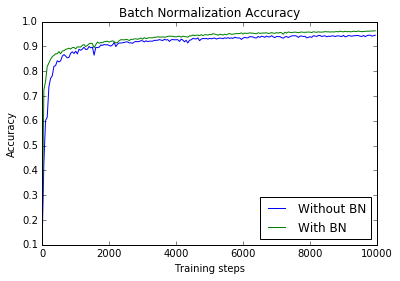

In [18]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

###### Illustration of input to activation functions over time

Below is the distribution over time of the inputs to the sigmoid activation function of the first five neurons in the network's second layer. Batch normalization has a visible and significant effect of removing variance/noise in these inputs. As described by Ioffe and Szegedy, this allows the third layer to learn faster and is responsible for the increase in accuracy and learning speed. See Figure 1 and Section 4.1 of the BN2015 paper.

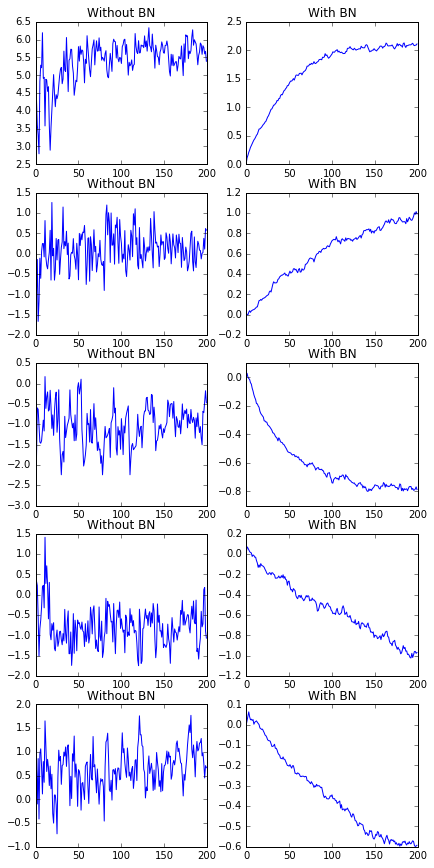

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

#### Making predictions with the model

As a final note: when actually putting a batch normalized model into practice, make sure to remember to replace the batch mean and batch variance in each batch normalization step with the mean and variance of the entire training set or population. In this particular model, I did not do this because the entire test set was predicted at once and the test set is large enough such that the mean and variance of the test set should be good estimates of the mean and variance of the population. See Section 3.1 of the BN2015 paper. 